# Geospatical Area Perimeter Estimation

## Introduction

Using RGB-PanSharpen data as the primary input for building footprint extraction because it offers a balance of high resolution and color information. The RGB-PanSharpen data is a combination of the panchromatic band and the red, green, and blue bands. The panchromatic band has a higher resolution than the multispectral bands, so the RGB-PanSharpen data has a higher resolution than the multispectral data. The RGB-PanSharpen data is also in color, so it provides more information than the panchromatic band alone.

We'll be calculating the area and perimeter of the buildings in the given image. To do this we'll need the Ground Surface Distance (GSD) of the image. The GSD is the distance between two consecutive pixel centers measured on the ground. The GSD is calculated as follows: Image Width (m) / Number of Pixels in Width. Using the aforementioned formula we know each tile is 200x200m and the image is 650x650 pixels. So the GSD is 0.3077m or 0.31m

## Approach

Since we have the GSD, image size, and mask. All we need to do to estimate size is create a model that generate a mask for the buildings in the image. Then we can calculate the area and perimeter of the buildings in the mask.

1. Load the TIFF images and corresponding building footprints (GeoJSON).
2. Preprocess the images
3. Convert footprints into binary masks (rasterize GeoJSON).
4. Train a segmentation model (ResNeXt + UNet).
5. Compute area and perimeter from the predicted mask.




## Imports 

In [ ]:
from PIL import Image
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import rasterio
from rasterio.enums import Resampling
from rasterio.transform import Affine
from rasterio import warp, features

## Download Dataset

In [ ]:
%%bash
aws s3 cp s3://spacenet-dataset/spacenet/SN2_buildings/tarballs/AOI_2_Vegas_Test_public.tar.gz dataset/backups/

In [ ]:
%%bash
aws s3 cp s3://spacenet-dataset/spacenet/SN2_buildings/tarballs/SN2_buildings_train_AOI_2_Vegas.tar.gz dataset/backups/

In [ ]:
%%bash
tar -xzf dataset/backups/AOI_2_Vegas_Test_public.tar.gz -C dataset/

In [ ]:
%%bash
tar -xzf dataset/backups/SN2_buildings_train_AOI_2_Vegas.tar.gz -C dataset/

## Preprocessing

* each image should be 650x650 pixels
* Normalize pixel values to a range (e.g., 0–1 or -1–1).
* Process image in place

In [ ]:
# Paths to training and testing datasets

# Train Images and Masks
train_folder = "dataset/AOI_2_Vegas_Train/RGB-PanSharpen"
train_masks_folder  = "dataset/AOI_2_Vegas_Train/geojson/buildings"

# Processed Training Images and Masks
processed_train_folder = "dataset/processed_images/AOI_2_Vegas_Train/RGB-PanSharpen-processed"
processed_mask_folder = "dataset/processed_masks/AOI_2_Vegas_Train/geojson"

# Test Images
test_folder = "dataset/AOI_2_Vegas_Test_public/RGB-PanSharpen"
processed_test_folder  = "dataset/processed_images/AOI_2_Vegas_Test_public/RGB-PanSharpen-processed"

In [ ]:
os.makedirs(processed_train_folder, exist_ok=True)
os.makedirs(processed_test_folder,  exist_ok=True)
os.makedirs(processed_mask_folder,  exist_ok=True)

In [13]:
# Function to normalize a band to 0–1
def normalize_band(band):
    return (band - band.min()) / (band.max() - band.min())


In [ ]:
def preprocess_tiff(image_path, out_folder):
    """
    1. Normalize each band to [0,1].
    2. Resample to 650×650.
    3. Save to 'out_folder'.
    4. Return (output_path, new_transform, crs).
    """
    os.makedirs(out_folder, exist_ok=True)

    filename = os.path.basename(image_path)
    out_path = os.path.join(out_folder, filename)

    with rasterio.open(image_path, "r") as src:
        meta = src.meta.copy()
        original_transform = src.transform
        original_crs = src.crs  # Save the CRS for later

        # Normalize bands
        bands = []
        for i in range(1, src.count + 1):
            band = src.read(i)
            band_norm = normalize_band(band)
            bands.append(band_norm)
        stacked_bands = np.stack(bands, axis=0)

        # Create new transform for 650×650
        new_transform = Affine(
            original_transform.a * (src.width / 650),
            original_transform.b,
            original_transform.c,
            original_transform.d,
            original_transform.e * (src.height / 650),
            original_transform.f
        )

        # Prepare array for resized bands
        resized_bands = np.zeros((src.count, 650, 650), dtype=np.float32)

        for i in range(src.count):
            resized_bands[i] = rasterio.warp.reproject(
                source=stacked_bands[i],
                destination=np.empty((650, 650), dtype=np.float32),
                src_transform=original_transform,
                src_crs=original_crs,
                dst_transform=new_transform,
                dst_crs=original_crs,
                resampling=Resampling.bilinear
            )[0]

        meta.update({
            "width": 650,
            "height": 650,
            "dtype": "float32",
            "transform": new_transform
        })

    # Write processed image
    with rasterio.open(out_path, "w", **meta) as dst:
        for i in range(resized_bands.shape[0]):
            dst.write(resized_bands[i], i+1)

    print(f"Saved preprocessed image to: {out_path}")
    return out_path, new_transform, original_crs

In [ ]:
def rasterize_geojson(geojson_path, reference_transform, reference_crs, out_mask_path):
    """
    Rasterize a GeoJSON file into 650×650 aligned to 'reference_transform' & 'reference_crs'.
    Polygon -> value=1; background=0.
    """
    if not os.path.isfile(geojson_path):
        print(f"[Warning] GeoJSON not found: {geojson_path}")
        return

    gdf = gpd.read_file(geojson_path)
    if gdf.crs != reference_crs:
        gdf = gdf.to_crs(reference_crs)

    shapes = [(geom, 1) for geom in gdf.geometry if geom is not None]
    mask = np.zeros((650, 650), dtype=np.uint8)

    mask = features.rasterize(
        shapes=shapes,
        out_shape=mask.shape,
        transform=reference_transform,
        fill=0,
        all_touched=False,
        dtype=np.uint8
    )

    mask_meta = {
        "driver": "GTiff",
        "height": 650,
        "width": 650,
        "count": 1,
        "dtype": "uint8",
        "crs": reference_crs,
        "transform": reference_transform
    }

    with rasterio.open(out_mask_path, "w", **mask_meta) as dst:
        dst.write(mask, 1)

    print(f"Rasterized mask saved to: {out_mask_path}")

In [ ]:
def preprocess_folder_images_only(in_image_folder, out_image_folder):
    """
    Preprocess each TIFF in 'in_image_folder' (normalize, resample) and save to 'out_image_folder'.
    No GeoJSON handling.
    """
    os.makedirs(out_image_folder, exist_ok=True)

    for file in os.listdir(in_image_folder):
        if file.endswith(".tif"):
            tiff_path = os.path.join(in_image_folder, file)
            print(f"Preprocessing: {tiff_path}")
            preprocess_tiff(tiff_path, out_image_folder)

    print(f"\nAll TIFFs in {in_image_folder} have been processed.")
    print(f"Processed images in: {out_image_folder}")

In [ ]:
def preprocess_folder_images_and_geojsons(
    in_image_folder, out_image_folder, 
    in_geojson_folder, out_geojson_folder
):
    """
    For each TIFF in 'in_image_folder':
      1) Preprocess TIFF -> 650×650.
      2) If a matching .geojson exists, rasterize it -> 650×650 mask.
    """
    os.makedirs(out_image_folder, exist_ok=True)
    os.makedirs(out_geojson_folder, exist_ok=True)

    for file in os.listdir(in_image_folder):
        if file.endswith(".tif"):
            tiff_path = os.path.join(in_image_folder, file)
            
            # 1) Preprocess the TIFF and get its transform/CRS
            out_tiff_path, new_transform, new_crs = preprocess_tiff(
                tiff_path,
                out_image_folder
            )

            # 2) Attempt to rasterize the corresponding GeoJSON
            base_name = os.path.splitext(file)[0]  # e.g. "image_1"
            geojson_name = base_name + ".geojson"
            geojson_path = os.path.join(in_geojson_folder, geojson_name)

            out_mask_name = base_name + "_mask.tif"
            out_mask_path = os.path.join(out_geojson_folder, out_mask_name)

            rasterize_geojson(
                geojson_path,
                reference_transform=new_transform,
                reference_crs=new_crs,
                out_mask_path=out_mask_path
            )

    print(f"\nAll TIFFs in {in_image_folder} have been processed.")
    print(f"Processed images in : {out_image_folder}")
    print(f"Rasterized masks in : {out_geojson_folder}")

In [ ]:
# Run preprocessing on training and testing datasets
preprocess_folder_images_and_geojsons(
    train_folder,
    processed_train_folder,
    train_masks_folder,
    processed_mask_folder
)

In [ ]:
preprocess_folder_images_only(
    test_folder,
    processed_test_folder
)

## Loading Data

In [ ]:
train_images = []
train_masks = []

In [ ]:
# Load all images and masks - this will be memory intensive ensure you have enough RAM
def load_images_and_masks(images_folder, masks_folder=None):
    """
    Loads all .tif images from `images_folder` into memory (as floats).
    If `masks_folder` is provided, loads corresponding .tif masks (as uint8).
    Assumes matching filenames or a known naming pattern.

    Returns:
        images: NumPy array of shape (N, H, W, C)
        masks: NumPy array of shape (N, H, W) or (N, H, W, 1), if masks_folder is given
    """
    # Collect all image paths
    image_paths = sorted(glob.glob(os.path.join(images_folder, "*.tif")))
    images_list = []
    masks_list = []

    for img_path in image_paths:
        # Read image
        with rasterio.open(img_path) as src:
            img_data = src.read()  # shape: (channels, height, width)
            img_data = np.transpose(img_data, (1, 2, 0))  # (height, width, channels)
            images_list.append(img_data.astype(np.float32))

        # If we have a masks folder, find matching mask
        if masks_folder is not None:
            # Example assumption: same filename in masks_folder
            basename = os.path.basename(img_path)  
            mask_path = os.path.join(masks_folder, basename)  
            # e.g., if mask files have "_mask.tif" appended:
            # base_no_ext = os.path.splitext(basename)[0]
            # mask_path = os.path.join(masks_folder, f"{base_no_ext}_mask.tif")

            if os.path.exists(mask_path):
                with rasterio.open(mask_path) as src_m:
                    mask_data = src_m.read(1)  # single band
                    masks_list.append(mask_data.astype(np.uint8))
            else:
                # If no mask found, append zeros or skip
                h, w, _ = img_data.shape
                masks_list.append(np.zeros((h, w), dtype=np.uint8))

    # Convert to NumPy arrays
    images = np.array(images_list, dtype=np.float32)

    if masks_folder is not None:
        # shape: (N, H, W)
        masks = np.array(masks_list, dtype=np.uint8)
        # Optionally expand to (N, H, W, 1) if needed for Keras
        # masks = np.expand_dims(masks, axis=-1)
        return images, masks
    else:
        return images

In [ ]:
# Load training data
train_images, train_masks = load_images_and_masks(train_folder, train_masks_folder)
print("train_images.shape:", train_images.shape)
print("train_masks.shape:", train_masks.shape)

In [ ]:
test_images = load_images_and_masks(train_folder)
print("train_images.shape:", train_images.shape)

## Modeling

## Prediction

## References

Van Etten, A., Lindenbaum, D., & Bacastow, T.M. (2018). SpaceNet: A Remote Sensing Dataset and Challenge Series. ArXiv, abs/1807.01232.

## Snippets

Image size: 650 x 650 (Width x Height)
Number of bands: 3
CRS: EPSG:4326
Transform: | 0.00, 0.00,-115.31|
| 0.00,-0.00, 36.21|
| 0.00, 0.00, 1.00|


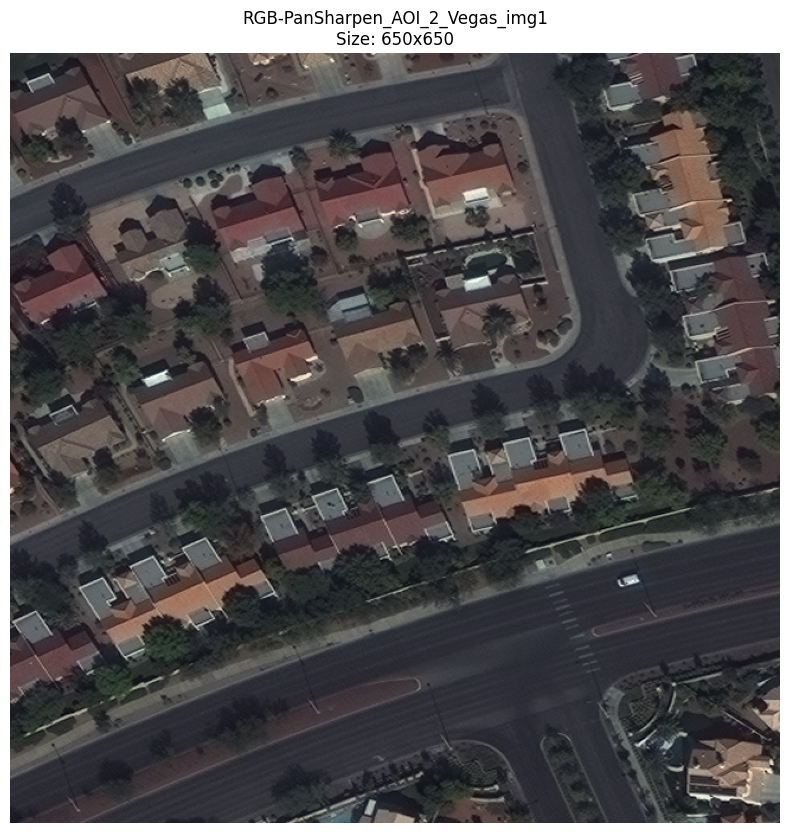

In [ ]:
## Visualize the first image

import rasterio
import numpy as np
from matplotlib import pyplot as plt

# Path to the first image
image_path = "AOI_2_Vegas_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img101.tif"

try:
    # Open the image using Rasterio
    with rasterio.open(image_path) as src:
        # Print image size and metadata
        print(f"Image size: {src.width} x {src.height} (Width x Height)")
        print(f"Number of bands: {src.count}")
        print(f"CRS: {src.crs}")
        print(f"Transform: {src.transform}")

        # Ensure the image has at least 3 bands (R, G, B)
        if src.count < 3:
            raise ValueError("The image does not have enough bands (expected at least 3).")

        # Read the first three bands (R, G, B)
        r = src.read(1)
        g = src.read(2)
        b = src.read(3)

        # Normalize each band individually to the range 0–255
        def normalize_band(band):
            return (band - band.min()) / (band.max() - band.min()) * 255

        r_normalized = normalize_band(r).astype(np.uint8)
        g_normalized = normalize_band(g).astype(np.uint8)
        b_normalized = normalize_band(b).astype(np.uint8)

        # Stack the normalized RGB bands
        rgb_normalized = np.stack((r_normalized, g_normalized, b_normalized), axis=-1)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_normalized)
    plt.title(f"RGB-PanSharpen_AOI_2_Vegas_img1\nSize: {src.width}x{src.height}")
    plt.axis("off")
    plt.show()

except FileNotFoundError:
    print(f"Error: The file {image_path} was not found.")
except ValueError as ve:
    print(f"Error: {ve}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Image size: 650 x 650 (Width x Height)
Number of bands: 3
CRS: EPSG:4326
Transform: | 0.00, 0.00,-115.31|
| 0.00,-0.00, 36.21|
| 0.00, 0.00, 1.00|


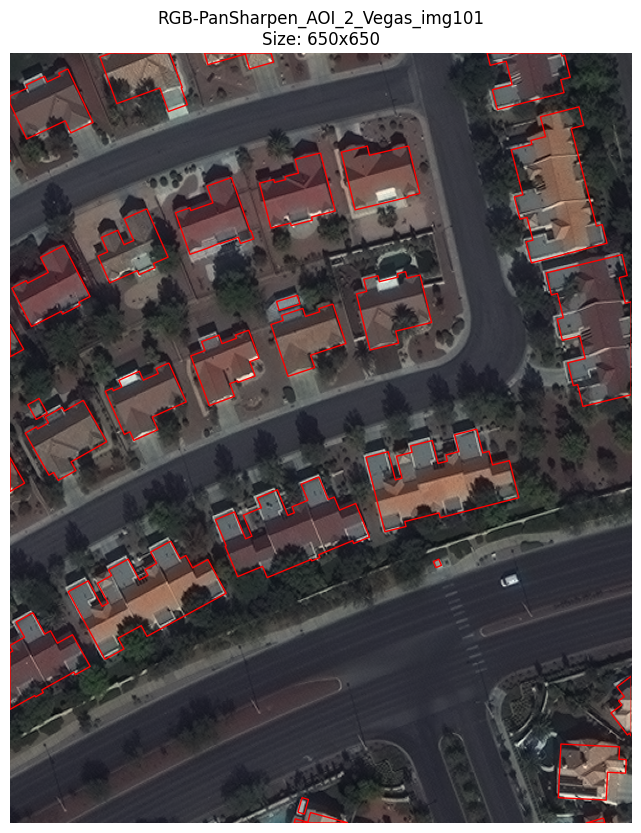

In [27]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.plot import show
import matplotlib.pyplot as plt

# Paths to the image and geojson mask
image_path = "AOI_2_Vegas_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img101.tif"
mask_path = "AOI_2_Vegas_Train/geojson/buildings/buildings_AOI_2_Vegas_img101.geojson"

try:
    # Open the image using Rasterio
    with rasterio.open(image_path) as src:
        # Print image size and metadata
        print(f"Image size: {src.width} x {src.height} (Width x Height)")
        print(f"Number of bands: {src.count}")
        print(f"CRS: {src.crs}")
        print(f"Transform: {src.transform}")

        # Ensure the image has at least 3 bands (R, G, B)
        if src.count < 3:
            raise ValueError("The image does not have enough bands (expected at least 3).")

        # Read the first three bands (R, G, B)
        r = src.read(1)
        g = src.read(2)
        b = src.read(3)

        # Normalize each band individually to the range 0–255
        def normalize_band(band):
            return (band - band.min()) / (band.max() - band.min()) * 255

        r_normalized = normalize_band(r).astype(np.uint8)
        g_normalized = normalize_band(g).astype(np.uint8)
        b_normalized = normalize_band(b).astype(np.uint8)

        # Stack the normalized bands into a single array of shape (3, height, width)
        rgb_array = np.stack([r_normalized, g_normalized, b_normalized], axis=0)

        # Read the GeoJSON mask into a GeoDataFrame
        gdf = gpd.read_file(mask_path)

        # Match the GeoDataFrame's CRS to the image CRS if they differ
        if gdf.crs != src.crs:
            gdf = gdf.to_crs(src.crs)

        # Create a figure and axis for plotting
        fig, ax = plt.subplots(figsize=(10, 10))

        # Use rasterio's show function to display the georeferenced image
        show(
            rgb_array,
            transform=src.transform,
            ax=ax
        )

        # Overlay the building footprints
        # facecolor='none' makes polygons transparent, edgecolor outlines them
        gdf.plot(ax=ax, facecolor='none', edgecolor='red')

        # Set title and remove axis ticks
        plt.title(f"RGB-PanSharpen_AOI_2_Vegas_img101\nSize: {src.width}x{src.height}")
        plt.axis("off")

        # Show the figure
        plt.show()

except FileNotFoundError:
    print(f"Error: The file {image_path} or {mask_path} was not found.")
except ValueError as ve:
    print(f"Error: {ve}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
